In [42]:
import pandas as pd
from bs4 import BeautifulSoup
import time
import requests
import re
import glob
from pandas.errors import EmptyDataError
from datetime import datetime

In [43]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [74]:
%%R

require(tidyverse)
require(ggplot2)

## Scrape "ice in" and "ice out" dates from Minnesota Department of Natural Resource.

In [75]:
# for lake_id in ids:
#     ice_in_url = f"https://maps1.dnr.state.mn.us/cgi-bin/climatology/ice_in_by_lake_as_csv.cgi?id={lake_id}"
#     response = requests.get(ice_in_url)
#     with open(f"data/ice_in/ice_in_{lake_id}.csv", "wb") as f:
#         f.write(response.content)
#     time.sleep(3)

In [76]:
# for lake_id in ids:
#     ice_out_url = f"https://maps1.dnr.state.mn.us/cgi-bin/climatology/ice_out_by_lake_as_csv.cgi?id={lake_id}"
#     response = requests.get(ice_out_url)
#     with open(f"data/ice_out/ice_out_{lake_id}.csv", "wb") as f:
#         f.write(response.content)
#     time.sleep(3)

## Build dataframe of lake names and IDs from website HTMLL

In [77]:
with open('lake_id.txt', "r") as file:
    raw_ids = file.read().strip()

In [78]:
name_and_id = re.findall(r'">([^<]*)</option', raw_ids)
name_and_id = name_and_id[1:]

In [79]:
lakes = {}

for lake in name_and_id:
    lake_id = lake.split(" - ")[1]
    lake_name = lake.split(" - ")[0]
    lakes[lake_id] = lake_name

In [80]:
lake_profiles = pd.DataFrame([lakes]).transpose().reset_index()
lake_profiles.columns = ['lake_id', 'lake_name']

## Analyze ice coverage data

#### Import and clean "ice in" dates

In [81]:
# Use glob to find all CSV files in the folder
ice_in = glob.glob("ice_in/*.csv")

# Create an empty DataFrame to store the concatenated data
df_in = pd.DataFrame()

# Loop over each CSV file and append it to the DataFrame
for f in ice_in:
    ice_in_data = pd.read_csv(f, header=2)
    id_from_file = f[-12:-4]
    ice_in_data["ID"] = id_from_file
    df_in = pd.concat([df_in, ice_in_data])

#### Import and clean "ice out" dates

In [82]:
# Use glob to find all CSV files in the folder
ice_out = glob.glob("ice_out/*.csv")

# Create an empty DataFrame to store the concatenated data
df_out = pd.DataFrame()

# Loop over each CSV file and appenfor f in ice_out:
for f in ice_out:
    try:
        ice_out_data = pd.read_csv(f, skiprows=2)
        id_from_file = f[-12:-4]
        ice_out_data["ID"] = id_from_file
        df_out = pd.concat([df_out, ice_out_data])
    except EmptyDataError:
        pass

#### Merge ice in and out data. Calculate ice days.

In [83]:
df_in.drop('Source', axis=1, inplace=True)
df_out.drop('Source', axis=1, inplace=True)

In [84]:
df = pd.merge(df_in, df_out, how="inner", on="ID")
df.columns = ['ice_in_date', 'lake_id', 'ice_out_date']
df = df[['lake_id', 'ice_in_date', 'ice_out_date']]

In [85]:
df.ice_in_date = pd.to_datetime(df.ice_in_date)
df.ice_out_date = pd.to_datetime(df.ice_out_date)

In [86]:
df['ice_days'] = df.ice_out_date - df.ice_in_date
df['ice_days'] = df['ice_days'].dt.days

In [87]:
df = df[(df.ice_days > 0) & (df.ice_days < 200)]

#### Merge lake id and lake name.

In [88]:
df = df.merge(lake_profiles, on="lake_id")

In [89]:
count = df.groupby('lake_id')['ice_days'].count().sort_values(ascending=False).reset_index()
count.columns = ['lake_id', 'measured_years']

In [90]:
df_with_measured_years = df.merge(count, on="lake_id")
df = df_with_measured_years

In [91]:
df['decade'] = (df.ice_in_date.dt.year//10)*10
df['decade'] = df['decade'].astype(str)
df['year'] = df.ice_in_date.dt.year
df['year'] = df['year'].astype(str)
# df['ice_in_month'] = df.ice_in_date.dt.month
# df['ice_out_month'] = df.ice_out_date.dt.month
# df['ice_in_month_date'] = df.ice_in_date.dt.month.astype(str)+'-'+df.ice_in_date.dt.day.astype(str)
# df['ice_out_month_date'] = df.ice_out_date.dt.month.astype(str)+'-'+df.ice_out_date.dt.day.astype(str)
df['ice_in_doy'] = df.ice_in_date.dt.dayofyear
df['ice_out_doy'] = df.ice_out_date.dt.dayofyear

#### Convert ice_in_date and ice_out_date into "day of year", starting from June 1st and ending in August 31st.

In [92]:
# pd.to_datetime(f'{df.year}-06-01')
# pd.to_datetime(f'2021-06-01')

df['aug_1st'] = pd.to_datetime(df.year+'-08-01')
df['aug_1st_doy'] = df.aug_1st.dt.dayofyear

df['ice_in_converted'] = df.ice_in_doy - df.aug_1st_doy
df['ice_out_converted'] = df.ice_out_doy + (365 - df.aug_1st_doy)

In [93]:
df

,lake_id,ice_in_date,ice_out_date,ice_days,lake_name,measured_years,decade,year,ice_in_doy,ice_out_doy,aug_1st,aug_1st_doy,ice_in_converted,ice_out_converted
0,82001000,1992-11-14,1993-04-12,149,McDonald,35,1990,1992,319,102,1992-08-01,214,105,253
1,82001000,1993-11-25,1994-04-01,127,McDonald,35,1990,1993,329,91,1993-08-01,213,116,243
2,82001000,1994-11-25,1995-04-15,141,McDonald,35,1990,1994,329,105,1994-08-01,213,116,257
3,82001000,1995-11-09,1996-04-19,162,McDonald,35,1990,1995,313,110,1995-08-01,213,100,262
4,82001000,1996-11-12,1997-04-11,150,McDonald,35,1990,1996,317,101,1996-08-01,214,103,252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4918,66003900,2007-12-01,2008-04-20,141,Mazaska,5,2000,2007,335,111,2007-08-01,213,122,263
4919,66003900,2017-12-07,2018-04-30,144,Mazaska,5,2010,2017,341,120,2017-08-01,213,128,272
4920,66003900,2017-12-07,2018-04-30,144,Mazaska,5,2010,2017,341,120,2017-08-01,213,128,272
4921,66003900,2019-12-02,2020-03-30,119,Mazaska,5,2010,2019,336,90,2019-08-01,213,123,242


In [94]:
# df['ice_in_month_datetime'] = pd.to_datetime(df['ice_in_month_date'], format='%m-%d')
# df['ice_in_month_day_dt'] = df['ice_in_month_datetime'].dt.strftime('%m-%d')

# df['ice_out_month_datetime'] = pd.to_datetime(df['ice_out_month_date'], format='%m-%d')
# df['ice_out_month_day_dt'] = df['ice_out_month_datetime'].dt.strftime('%m-%d')

# # df.drop(['ice_in_month_datetime', 'ice_out_month_datetime', 'ice_in_month_date', 'ice_out_month_date'], axis=1, inplace=True)

In [95]:
df.drop_duplicates(inplace=True)

In [96]:
# Exclude lakes with 7 or fewer observations

df = df[~df.measured_years<8]

In [97]:
yearly_df = pd.DataFrame(df.groupby('year')['ice_days'].mean())
yearly_df['num_lakes'] = df.groupby('year')['lake_id'].count()

yearly_df.reset_index(inplace=True)

In [98]:
# min_samplesize = 10

# yearly_min_sample_df =  yearly_df[yearly_df.num_lakes >= min_samplesize]

# sample_years = ['1960', '1965', '1970', '1975', '1980', '1985', '1990', '1995','2000', '2005','2010', '2015','2020']
# sample_years_df = df[df.year.astype(str).isin(sample_years)]
# sample_years_df.year = sample_years_df.year.astype(str)

<AxesSubplot: xlabel='year'>

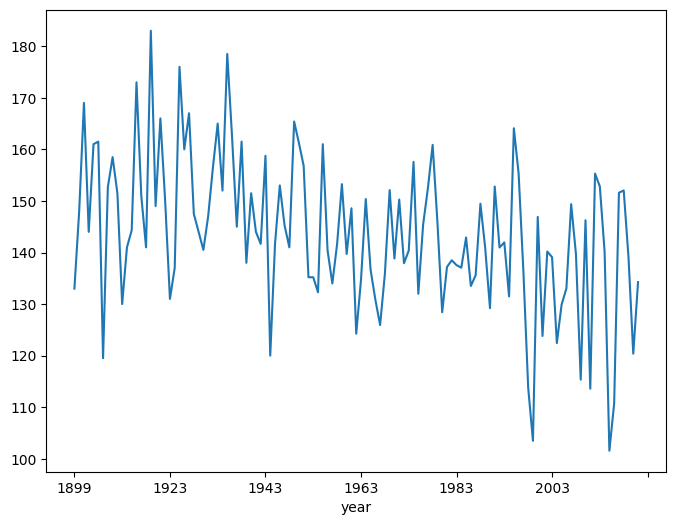

In [99]:
plt.figure(figsize=(8, 6))

df.groupby('year').ice_days.mean().plot()

### Build graphs using ggplot

In [105]:
df 

,lake_id,ice_in_date,ice_out_date,ice_days,lake_name,measured_years,decade,year,ice_in_doy,ice_out_doy,aug_1st,aug_1st_doy,ice_in_converted,ice_out_converted
0,82001000,1992-11-14,1993-04-12,149,McDonald,35,1990,1992,319,102,1992-08-01,214,105,253
1,82001000,1993-11-25,1994-04-01,127,McDonald,35,1990,1993,329,91,1993-08-01,213,116,243
2,82001000,1994-11-25,1995-04-15,141,McDonald,35,1990,1994,329,105,1994-08-01,213,116,257
3,82001000,1995-11-09,1996-04-19,162,McDonald,35,1990,1995,313,110,1995-08-01,213,100,262
4,82001000,1996-11-12,1997-04-11,150,McDonald,35,1990,1996,317,101,1996-08-01,214,103,252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,29061000,2019-11-07,2020-04-27,172,Arco,4,2010,2019,311,118,2019-08-01,213,98,270
4918,66003900,2007-12-01,2008-04-20,141,Mazaska,5,2000,2007,335,111,2007-08-01,213,122,263
4919,66003900,2017-12-07,2018-04-30,144,Mazaska,5,2010,2017,341,120,2017-08-01,213,128,272
4921,66003900,2019-12-02,2020-03-30,119,Mazaska,5,2010,2019,336,90,2019-08-01,213,123,242


## Analyze specific lakes

### Only look into lakes with at lease 50 years of observed data

In [108]:
df_50plus = df[df.measured_years>=50]

In [109]:
df_50plus.lake_name.unique()

array(['Little Rock', 'Bemidji', 'Eighth Crow Wing', 'George',
       'Farm Island', 'Wabana', 'Green', 'Burntside', 'Portage',
       'Kabekona', 'Washington', 'Lake of the Isles', 'Little McDonald',
       'Long', 'Shagawa', 'Upper Prior', 'Detroit', 'Harriet',
       'Floyd (south bay)', 'Minnetonka', 'Turtle', 'Wirth', 'Itasca',
       'Bde Maka Ska', 'Pelican', 'Waconia', 'Bad Medicine'], dtype=object)

In [110]:
bemidji = df.query("lake_name=='Bemidji'")
bemidji.drop_duplicates(inplace=True)

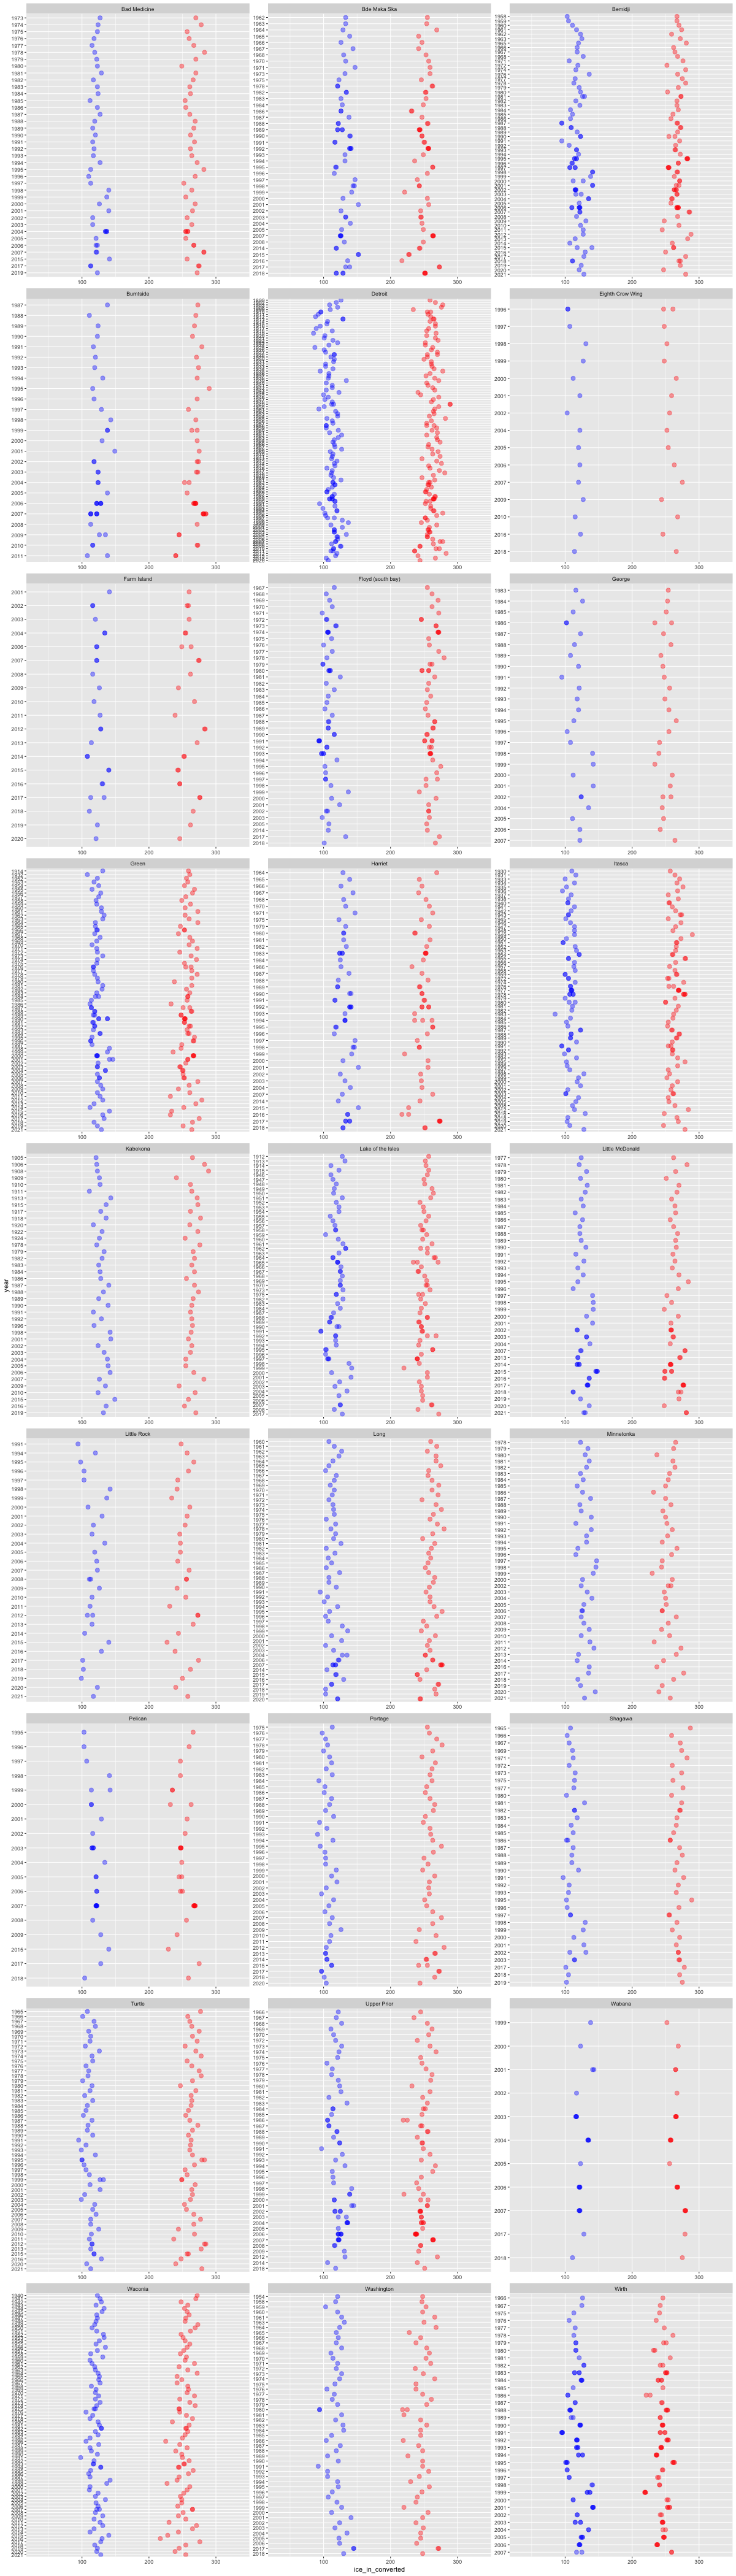

In [112]:
%%R -i df_50plus -w 1200 -h 4200

# plot all lakes

ggplot(df_50plus) +
    geom_point(aes(x=ice_in_converted, y = year), size = 3, color='blue', alpha=0.4) +
    geom_point(aes(x=ice_out_converted, y = year), size = 3, color='red', alpha=0.4) +
    xlim(32, 335) +
    scale_y_discrete(limits=rev) +
    facet_wrap(~lake_name, scales="free", ncol = 3)

Lakes to zoom into:
1. Bemidji
2. Detroit
3. Waconia

In [113]:
sample_lakes = ['Bemidji', 'Detroit', 'Waconia']
sample_lakes_df = df[df["lake_name"].isin(sample_lakes)]

In [114]:
sample_year_lakes_df = sample_lakes_df[((sample_lakes_df.year.astype(int)%5)==0) & (sample_lakes_df.year.astype(int)>1940)]

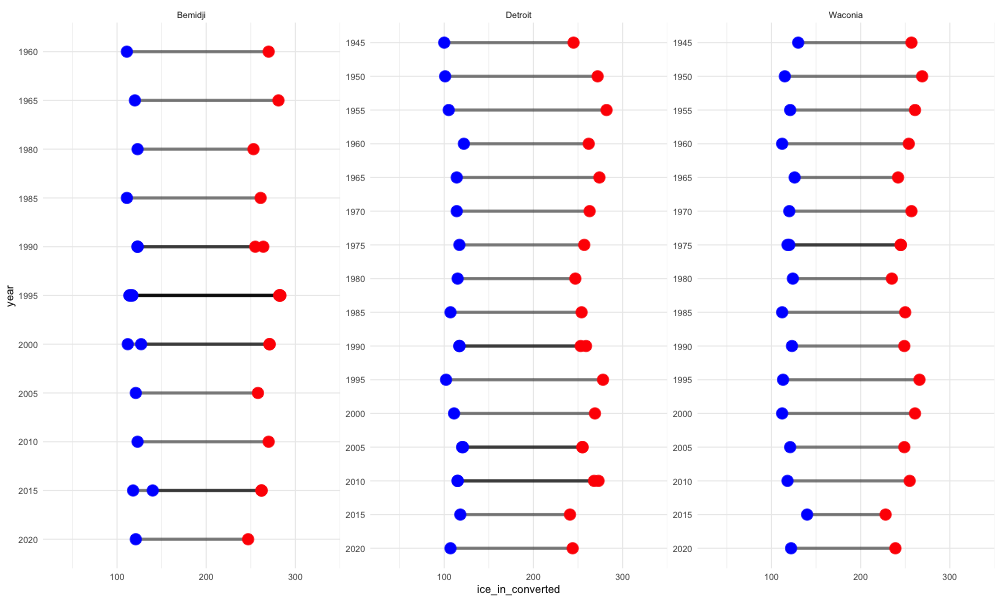

In [115]:
%%R -i sample_year_lakes_df -w 1000 -h 600

# Plot sample lakes.

ggplot(sample_year_lakes_df) +
    geom_segment(aes(x=ice_in_converted, y=year, xend=ice_out_converted, yend=year), color="black", size=1.5, alpha=0.5) +
    geom_point(aes(x=ice_in_converted, y = year), size = 5, color='blue') +
    geom_point(aes(x=ice_out_converted, y = year), size = 5, color='red') +
    xlim(32, 335) +
    scale_y_discrete(limits=rev) +
    theme_minimal() + 
    facet_wrap(~lake_name, scales="free", ncol = 3)

## Analysis: Lake Bemidji

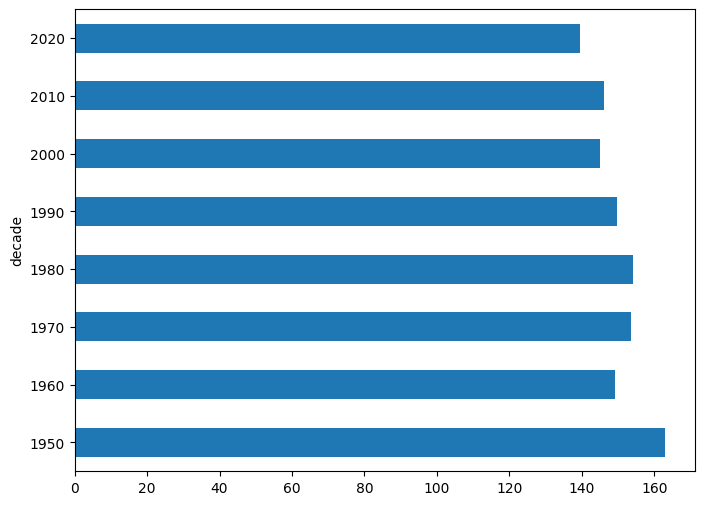

In [116]:
plt.figure(figsize=(8, 6))
bemidji.groupby('decade')['ice_days'].mean().plot(kind='barh')

plt.savefig('bemidji_icedays.pdf')

In [117]:
bemidji.groupby('decade')['ice_days'].mean()

decade
1950    163.000000
1960    149.125000
1970    153.714286
1980    154.153846
1990    149.750000
2000    145.000000
2010    146.250000
2020    139.500000
Name: ice_days, dtype: float64

In [118]:
# bemidji_sample = df[(df.lake_name=='Bemidji') & (df.year.astype(int) > 1930) & (df.year.astype(int)&2==0)]
bemidji_sample = bemidji[(bemidji.year.astype(int) > 1940) & (bemidji.year.astype(int)%10==0)]

In [119]:
def day_to_week(day_of_year):
    date = datetime.strptime(str(day_of_year), '%j')
    year, week_num, day_of_week = date.isocalendar()
    return week_num

In [120]:
bemidji_in = bemidji.groupby('decade').ice_in_doy.mean().reset_index()
bemidji_in['circle_unit'] = round((bemidji_in.ice_in_doy-305)/5)+1

bemidji_in

,decade,ice_in_doy,circle_unit
0,1950,317.000000,3.0
1,1960,333.125000,7.0
2,1970,331.285714,6.0
3,1980,326.307692,5.0
4,1990,330.550000,6.0
5,2000,335.478261,7.0
6,2010,334.916667,7.0
7,2020,338.000000,8.0


In [121]:
bemidji_out = bemidji.groupby('decade').ice_out_doy.mean().reset_index()
bemidji_out['circle_unit'] = round((bemidji_out.ice_out_doy)/5)

bemidji_out

,decade,ice_out_doy,circle_unit
0,1950,115.000000,23.0
1,1960,117.000000,23.0
2,1970,119.714286,24.0
3,1980,115.153846,23.0
4,1990,115.150000,23.0
5,2000,115.260870,23.0
6,2010,116.000000,23.0
7,2020,112.000000,22.0


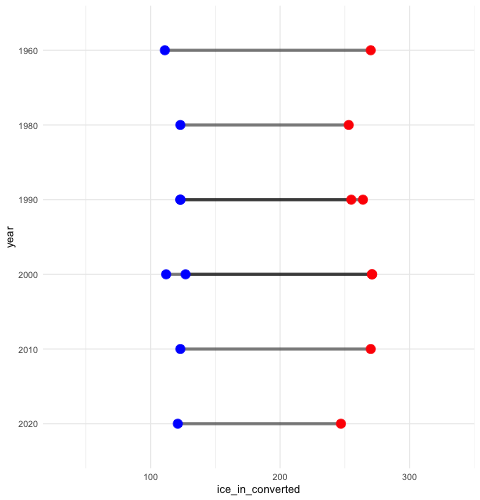

In [122]:
%%R -i bemidji_sample -h 500

# Plot individual charts

plot_lake <- function(lake) {
    ggplot(lake) +
        geom_segment(aes(x=ice_in_converted, y=year, xend=ice_out_converted, yend=year), color="black", size=1.5, alpha=0.5) +
        geom_point(aes(x=ice_in_converted, y = year), size = 4, color='blue') +
        geom_point(aes(x=ice_out_converted, y = year), size = 4, color='red') +
        xlim(32, 335) +
        scale_y_discrete(limits=rev) +
        theme_minimal()
    }

plot_lake(bemidji_sample)

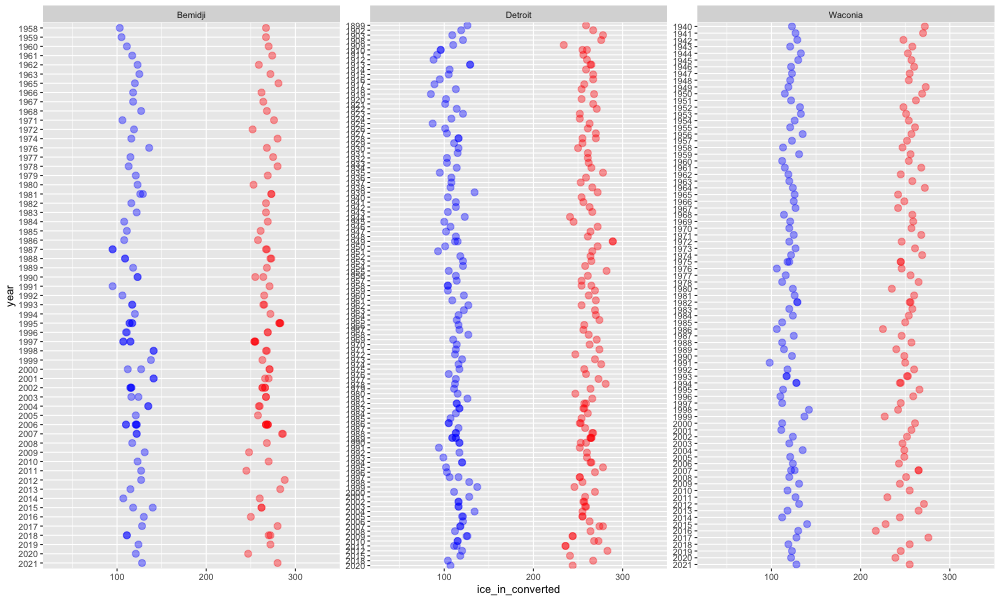

In [123]:
%%R -i sample_lakes_df -w 1000 -h 600

# Plot sample lakes.

ggplot(sample_lakes_df) +
    geom_point(aes(x=ice_in_converted, y = year), size = 3, color='blue', alpha=0.4) +
    geom_point(aes(x=ice_out_converted, y = year), size = 3, color='red', alpha=0.4) +
    xlim(32, 335) +
    scale_y_discrete(limits=rev) +
    facet_wrap(~lake_name, scales="free", ncol = 3)

In [124]:
lake = df.query("lake_name=='Nokomis'")
lake.groupby('decade')['ice_days'].mean()

decade
1960    132.333333
1980    133.000000
1990    127.100000
2000    122.750000
2010    113.500000
Name: ice_days, dtype: float64

In [125]:
lake = df.query("lake_name=='Waconia'")
lake.groupby('decade')['ice_days'].mean()

decade
1940    135.500000
1950    130.800000
1960    134.700000
1970    137.400000
1980    128.909091
1990    129.250000
2000    130.909091
2010    124.200000
2020    122.500000
Name: ice_days, dtype: float64

In [126]:
lake = df[df.lake_name.str.contains('Peltier')]
lake.groupby('decade')['ice_days'].mean()

Series([], Name: ice_days, dtype: float64)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


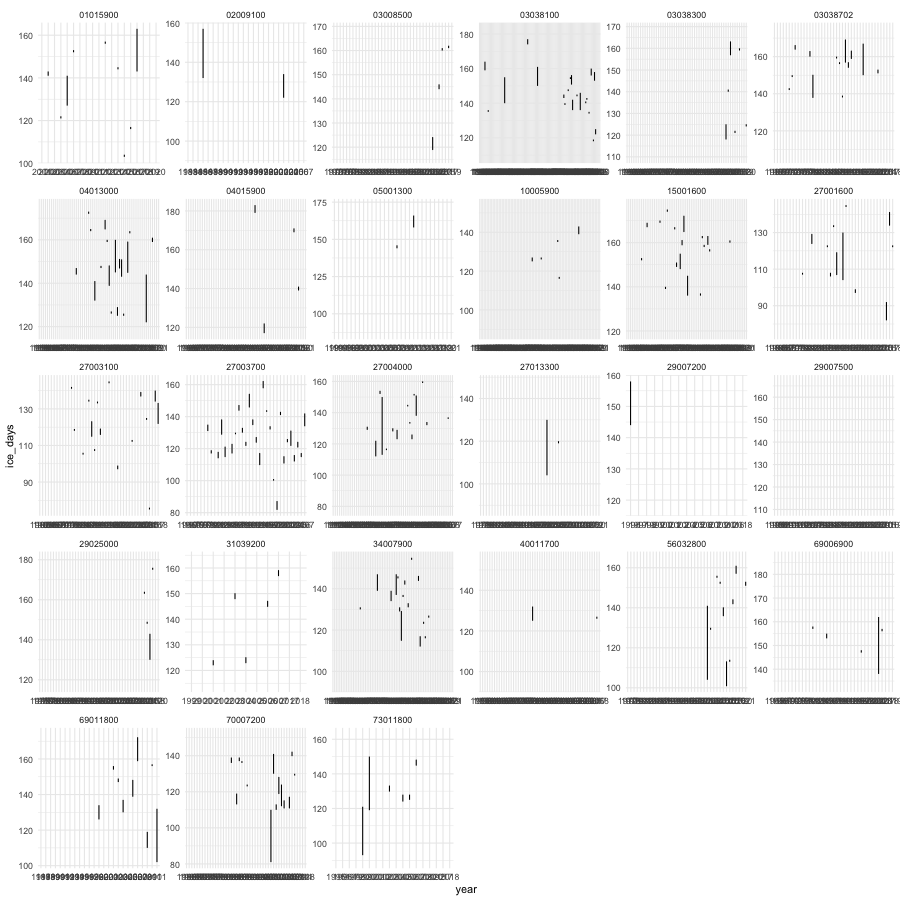

In [127]:
%%R -i df_50plus -w 900 -h 900

ggplot(df_50plus) +
    aes(x=year, y=ice_days) + 
    geom_line() +
    facet_wrap(~lake_id, scales="free") +
    theme_minimal()